In [50]:
# Imports
import mne
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

Using: cuda


In [51]:
# ========================================
# REFACTORED MODULAR GAN SYSTEM - FIXED
# ========================================

class EEGGANTrainer:
    """
    Improved GAN trainer for EEG data with WGAN-GP support
    
    Usage:
        trainer = EEGGANTrainer(data, name='my_experiment', gan_type='wgan-gp')
        trainer.train(epochs=300)
        synthetic = trainer.generate(n_samples=100)
    """
    
    def __init__(self, data, name='experiment', device='cpu', gan_type='vanilla'):
        """
        Initialize GAN trainer
        
        Parameters:
        -----------
        data : numpy array
            EEG data with shape (n_samples, n_channels, n_timepoints)
        name : str
            Name for this experiment
        device : str
            'cpu' or 'cuda'
        gan_type : str
            'vanilla' or 'wgan-gp'
        """
        self.data = data
        self.name = name
        self.device = device
        self.gan_type = gan_type
        
        self.n_samples = data.shape[0]
        self.n_channels = data.shape[1]
        self.n_timepoints = data.shape[2]
        
        print(f"Initialized EEGGANTrainer ({gan_type}): {name}")
        print(f"  Data: {data.shape}")
        print(f"  Device: {device}")
        
        self._create_models()
        self._create_dataset()
        
        self.history = {'G_losses': [], 'D_losses': [], 'metrics': []}
        self.best_metric = float('inf')
        self.best_epoch = 0
    
    def _create_models(self):
        """Create Generator and Discriminator/Critic"""
        data_size = self.n_channels * self.n_timepoints
        
        # FIXED: Remove Tanh for WGAN-GP generator (it clips output range!)
        self.G = nn.Sequential(
            nn.Linear(data_size, 2048),
            nn.LayerNorm(2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(2048, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, data_size)
            # REMOVED Tanh - it was limiting the output range too much!
        ).to(self.device)
        
        # Discriminator/Critic
        layers = [
            nn.Linear(data_size, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            
            nn.Linear(128, 1)
        ]
        
        if self.gan_type == 'vanilla':
            layers.append(nn.Sigmoid())
        
        self.D = nn.Sequential(*layers).to(self.device)
        
        print(f"✓ Models created")
        print(f"  Generator: {sum(p.numel() for p in self.G.parameters()):,} params")
        print(f"  {'Critic' if self.gan_type == 'wgan-gp' else 'Discriminator'}: {sum(p.numel() for p in self.D.parameters()):,} params")
    
    def _create_dataset(self):
        """Create PyTorch dataset"""
        class EEGDataset(Dataset):
            def __init__(self, data):
                self.data = torch.FloatTensor(data)
            def __len__(self):
                return len(self.data)
            def __getitem__(self, idx):
                return self.data[idx]
        
        dataset = EEGDataset(self.data)
        self.dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        print(f"✓ Dataset: {len(dataset)} samples, {len(self.dataloader)} batches")
    
    def _compute_gradient_penalty(self, real, fake):
        """Gradient penalty for WGAN-GP"""
        batch_size = real.size(0)
        alpha = torch.rand(batch_size, 1, device=self.device)
        
        real_flat = real.reshape(batch_size, -1)
        fake_flat = fake.reshape(batch_size, -1)
        
        interpolates = (alpha * real_flat + (1 - alpha) * fake_flat).requires_grad_(True)
        d_interpolates = self.D(interpolates)
        
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(d_interpolates),
            create_graph=True,
            retain_graph=True
        )[0]
        
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty
    
    def train(self, epochs=300, lr=0.0001, save_best=True):
        """Train GAN (vanilla or WGAN-GP)"""
        if self.gan_type == 'vanilla':
            self._train_vanilla(epochs, lr, save_best)
        else:
            self._train_wgan_gp(epochs, lr, save_best)
    
    def _train_vanilla(self, epochs, lr, save_best):
        """Vanilla GAN training"""
        criterion = nn.BCELoss()
        G_opt = optim.Adam(self.G.parameters(), lr=lr, betas=(0.5, 0.999))
        D_opt = optim.Adam(self.D.parameters(), lr=lr, betas=(0.5, 0.999))
        
        print(f"\nTraining Vanilla GAN for {epochs} epochs...")
        print("="*60)
        
        for epoch in range(epochs):
            G_losses, D_losses = [], []
            
            for real_eeg in self.dataloader:
                real_eeg = real_eeg.to(self.device)
                batch_size = real_eeg.shape[0]
                
                # Train Discriminator
                D_opt.zero_grad()
                real_pred = self.D(real_eeg.reshape(batch_size, -1))
                real_labels = torch.ones(batch_size, 1, device=self.device) * 0.9
                loss_real = criterion(real_pred, real_labels)
                
                noise = torch.randn_like(real_eeg, device=self.device)
                fake_eeg = self.G(noise.reshape(batch_size, -1))
                fake_pred = self.D(fake_eeg.detach())
                fake_labels = torch.zeros(batch_size, 1, device=self.device)
                loss_fake = criterion(fake_pred, fake_labels)
                
                D_loss = (loss_real + loss_fake) / 2
                D_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.D.parameters(), 1.0)
                D_opt.step()
                
                # Train Generator
                G_opt.zero_grad()
                noise = torch.randn_like(real_eeg, device=self.device)
                fake_eeg = self.G(noise.reshape(batch_size, -1))
                fake_pred = self.D(fake_eeg)
                
                G_loss = criterion(fake_pred, torch.ones(batch_size, 1, device=self.device))
                G_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.G.parameters(), 1.0)
                G_opt.step()
                
                G_losses.append(G_loss.item())
                D_losses.append(D_loss.item())
            
            self.history['G_losses'].append(np.mean(G_losses))
            self.history['D_losses'].append(np.mean(D_losses))
            
            if (epoch + 1) % 20 == 0:
                metric = self._evaluate()
                self.history['metrics'].append(metric)
                
                if save_best and metric < self.best_metric:
                    self.best_metric = metric
                    self.best_epoch = epoch + 1
                    self.save_model()
                
                print(f"Epoch {epoch+1:3d}/{epochs} | D: {self.history['D_losses'][-1]:.4f} | "
                      f"G: {self.history['G_losses'][-1]:.4f} | Metric: {metric:.4f}")
        
        print("="*60)
        print(f"✓ Training complete! Best: {self.best_metric:.4f} @ epoch {self.best_epoch}")
        if save_best:
            self.load_best_model()
    
    def _train_wgan_gp(self, epochs, lr, save_best, lambda_gp=10, n_critic=5):
        """WGAN-GP training - FIXED"""
        # FIXED: Use RMSprop instead of Adam for WGAN-GP (more stable)
        G_opt = optim.RMSprop(self.G.parameters(), lr=lr * 0.5)
        D_opt = optim.RMSprop(self.D.parameters(), lr=lr)
        
        print(f"\nTraining WGAN-GP for {epochs} epochs...")
        print("="*60)
        
        for epoch in range(epochs):
            G_losses, D_losses = [], []
            
            for real_eeg in self.dataloader:
                real_eeg = real_eeg.to(self.device)
                batch_size = real_eeg.shape[0]
                
                # Train Critic multiple times
                for _ in range(n_critic):
                    D_opt.zero_grad()
                    
                    real_score = self.D(real_eeg.reshape(batch_size, -1))
                    
                    noise = torch.randn_like(real_eeg, device=self.device)
                    fake_eeg = self.G(noise.reshape(batch_size, -1))
                    fake_score = self.D(fake_eeg.detach())
                    
                    gp = self._compute_gradient_penalty(
                        real_eeg, 
                        fake_eeg.reshape(batch_size, self.n_channels, self.n_timepoints)
                    )
                    
                    # FIXED: Wasserstein loss (negative because we want to maximize distance)
                    D_loss = fake_score.mean() - real_score.mean() + lambda_gp * gp
                    
                    D_loss.backward()
                    D_opt.step()
                    D_losses.append(D_loss.item())
                
                # Train Generator
                G_opt.zero_grad()
                noise = torch.randn_like(real_eeg, device=self.device)
                fake_eeg = self.G(noise.reshape(batch_size, -1))
                fake_score = self.D(fake_eeg)
                
                # Generator wants critic to give high score to fake
                G_loss = -fake_score.mean()
                
                G_loss.backward()
                G_opt.step()
                G_losses.append(G_loss.item())
            
            self.history['G_losses'].append(np.mean(G_losses))
            self.history['D_losses'].append(np.mean(D_losses))
            
            if (epoch + 1) % 20 == 0:
                metric = self._evaluate()
                self.history['metrics'].append(metric)
                
                if save_best and metric < self.best_metric:
                    self.best_metric = metric
                    self.best_epoch = epoch + 1
                    self.save_model()
                
                print(f"Epoch {epoch+1:3d}/{epochs} | C: {self.history['D_losses'][-1]:.4f} | "
                      f"G: {self.history['G_losses'][-1]:.4f} | Metric: {metric:.4f}")
        
        print("="*60)
        print(f"✓ Training complete! Best: {self.best_metric:.4f} @ epoch {self.best_epoch}")
        if save_best:
            self.load_best_model()
    
    def _evaluate(self):
        """Evaluate model quality"""
        with torch.no_grad():
            noise = torch.randn(100, self.n_channels, self.n_timepoints, device=self.device)
            fake = self.G(noise.reshape(100, -1))
            fake_reshaped = fake.reshape(100, self.n_channels, self.n_timepoints)
            fake_std = fake_reshaped.cpu().numpy().std()
            real_std = self.data.std()
            return abs(fake_std - real_std)
    
    def generate(self, n_samples=100):
        """Generate synthetic samples"""
        self.G.eval()
        samples = []
        
        with torch.no_grad():
            for i in range(n_samples):
                noise = torch.randn(1, self.n_channels, self.n_timepoints, device=self.device)
                fake = self.G(noise.reshape(1, -1))
                fake_reshaped = fake.reshape(self.n_channels, self.n_timepoints)
                samples.append(fake_reshaped.cpu().numpy())
        
        return np.array(samples)
    
    def save_model(self):
        """Save model"""
        os.makedirs('../../models', exist_ok=True)
        path = f'../../models/gan_{self.name}_{self.gan_type}.pt'
        torch.save({
            'G': self.G.state_dict(), 
            'D': self.D.state_dict(),
            'history': self.history
        }, path)
    
    def load_best_model(self):
        """Load best model"""
        path = f'../../models/gan_{self.name}_{self.gan_type}.pt'
        checkpoint = torch.load(path)
        self.G.load_state_dict(checkpoint['G'])
        self.D.load_state_dict(checkpoint['D'])
        print(f"✓ Loaded best model from {path}")
    
    def evaluate(self, synthetic_data):
        """Comprehensive evaluation"""
        mean_error = abs(self.data.mean() - synthetic_data.mean())
        std_error = abs(self.data.std() - synthetic_data.std())
        
        n_eval = min(1000, len(self.data), len(synthetic_data))
        mmd = self._compute_mmd(self.data[:n_eval], synthetic_data[:n_eval])
        
        stat_score = max(0, 100 - (mean_error * 1000 + std_error * 100))
        mmd_score = max(0, 100 - (mmd * 1000))
        overall = (stat_score + mmd_score) / 2
        
        return {
            'mean_error': mean_error,
            'std_error': std_error,
            'mmd_rbf': mmd,
            'stat_score': stat_score,
            'mmd_score': mmd_score,
            'overall_score': overall,
            'quality': self._get_quality_label(overall)
        }
    
    def _compute_mmd(self, real_data, fake_data):
        """Compute MMD"""
        real_flat = torch.FloatTensor(real_data.reshape(real_data.shape[0], -1))
        fake_flat = torch.FloatTensor(fake_data.reshape(fake_data.shape[0], -1))
        
        def gaussian_kernel(x, y):
            x_norm = (x ** 2).sum(1).view(-1, 1)
            y_norm = (y ** 2).sum(1).view(1, -1)
            dist = x_norm + y_norm - 2.0 * torch.mm(x, y.t())
            gamma = 1.0 / (2 * torch.median(dist[dist > 0]))
            return torch.exp(-gamma * dist)
        
        K_rr = gaussian_kernel(real_flat, real_flat)
        K_ff = gaussian_kernel(fake_flat, fake_flat)
        K_rf = gaussian_kernel(real_flat, fake_flat)
        
        n_r, n_f = len(real_flat), len(fake_flat)
        mmd_sq = (K_rr.sum() / (n_r * (n_r - 1)) +
                  K_ff.sum() / (n_f * (n_f - 1)) -
                  2 * K_rf.sum() / (n_r * n_f))
        
        return torch.sqrt(torch.clamp(mmd_sq, min=0.0)).item()
    
    def _get_quality_label(self, score):
        """Quality label"""
        if score >= 80: return "Excellent ⭐⭐⭐⭐⭐"
        if score >= 60: return "Good ⭐⭐⭐⭐"
        if score >= 40: return "Fair ⭐⭐⭐"
        return "Needs Improvement ⭐⭐"
    
    def plot_comparison(self, synthetic_data, save_path=None):
        """Plot comparison"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 8))
        
        axes[0, 0].plot(self.data[0].T, alpha=0.5, linewidth=0.5)
        axes[0, 0].set_title(f'Real {self.name}', fontweight='bold')
        axes[0, 0].set_ylim(-4, 4)
        
        axes[0, 1].plot(synthetic_data[0].T, alpha=0.5, linewidth=0.5)
        axes[0, 1].set_title(f'Generated {self.name} ({self.gan_type})', fontweight='bold')
        axes[0, 1].set_ylim(-4, 4)
        
        axes[1, 0].plot(self.data[0, 0], label='Real', alpha=0.7, linewidth=2)
        axes[1, 0].plot(synthetic_data[0, 0], label='Generated', alpha=0.7, linewidth=2)
        axes[1, 0].set_title('Single Channel', fontweight='bold')
        axes[1, 0].legend()
        
        axes[1, 1].hist(self.data.flatten(), bins=50, alpha=0.5, label='Real', density=True)
        axes[1, 1].hist(synthetic_data.flatten(), bins=50, alpha=0.5, label='Generated', density=True)
        axes[1, 1].set_title('Distribution', fontweight='bold')
        axes[1, 1].legend()
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150)
        plt.show()
    
    def save_results(self, synthetic_data, evaluation):
        """Save results"""
        os.makedirs('../../synthetic_data', exist_ok=True)
        np.save(f'../../synthetic_data/synthetic_{self.name}_{self.gan_type}.npy', synthetic_data)
        np.save(f'../../synthetic_data/evaluation_{self.name}_{self.gan_type}.npy', evaluation)
        print(f"✓ Saved results for {self.name} ({self.gan_type})")

print("✓ FIXED EEGGANTrainer loaded")

✓ FIXED EEGGANTrainer loaded


In [52]:
# Load individual segment files from eyes_closed_individual folder
import glob

# Path to individual segments
individual_dir_closed = os.path.join('..', '..', 'gan_data', 'eyes_closed_individual')
individual_dir_open = os.path.join('..', '..', 'gan_data', 'eyes_open_individual')

# Get all individual segment files
closed_files = sorted(glob.glob(os.path.join(individual_dir_closed, '*.npy')))
open_files = sorted(glob.glob(os.path.join(individual_dir_open, '*.npy')))

print(f"Found {len(closed_files)} eyes closed segments")
print(f"Found {len(open_files)} eyes open segments")

# Load all individual segments
segments_closed = np.array([np.load(f) for f in closed_files])
segments_open = np.array([np.load(f) for f in open_files])

print(f"\n✓ Loaded eyes closed: {segments_closed.shape}")
print(f"✓ Loaded eyes open: {segments_open.shape}")

Found 66 eyes closed segments
Found 74 eyes open segments

✓ Loaded eyes closed: (66, 129, 500)
✓ Loaded eyes open: (74, 129, 500)


✓ Using eyes open data: (74, 129, 500)
Initialized EEGGANTrainer (vanilla): eyes_open
  Data: (74, 129, 500)
  Device: cuda
✓ Models created
  Generator: 167,816,692 params
  Discriminator: 33,190,401 params
✓ Dataset: 74 samples, 3 batches

Training Vanilla GAN for 300 epochs...
Epoch  20/300 | D: 0.1801 | G: 3.9339 | Metric: 0.4818
Epoch  40/300 | D: 0.1883 | G: 4.9295 | Metric: 0.4330
Epoch  60/300 | D: 0.2373 | G: 4.6070 | Metric: 0.2972
Epoch  80/300 | D: 0.1907 | G: 7.3660 | Metric: 0.3029
Epoch 100/300 | D: 0.1753 | G: 6.4882 | Metric: 0.1239
Epoch 120/300 | D: 0.2120 | G: 5.6457 | Metric: 0.2845
Epoch 140/300 | D: 0.2442 | G: 5.8727 | Metric: 0.1575
Epoch 160/300 | D: 0.1983 | G: 6.7466 | Metric: 0.1125
Epoch 180/300 | D: 0.2113 | G: 6.5214 | Metric: 0.0268
Epoch 200/300 | D: 0.2264 | G: 7.1313 | Metric: 0.0463
Epoch 220/300 | D: 0.3030 | G: 4.7532 | Metric: 0.0852
Epoch 240/300 | D: 0.2747 | G: 4.1291 | Metric: 0.1314
Epoch 260/300 | D: 0.2351 | G: 3.7108 | Metric: 0.2198
Epoc

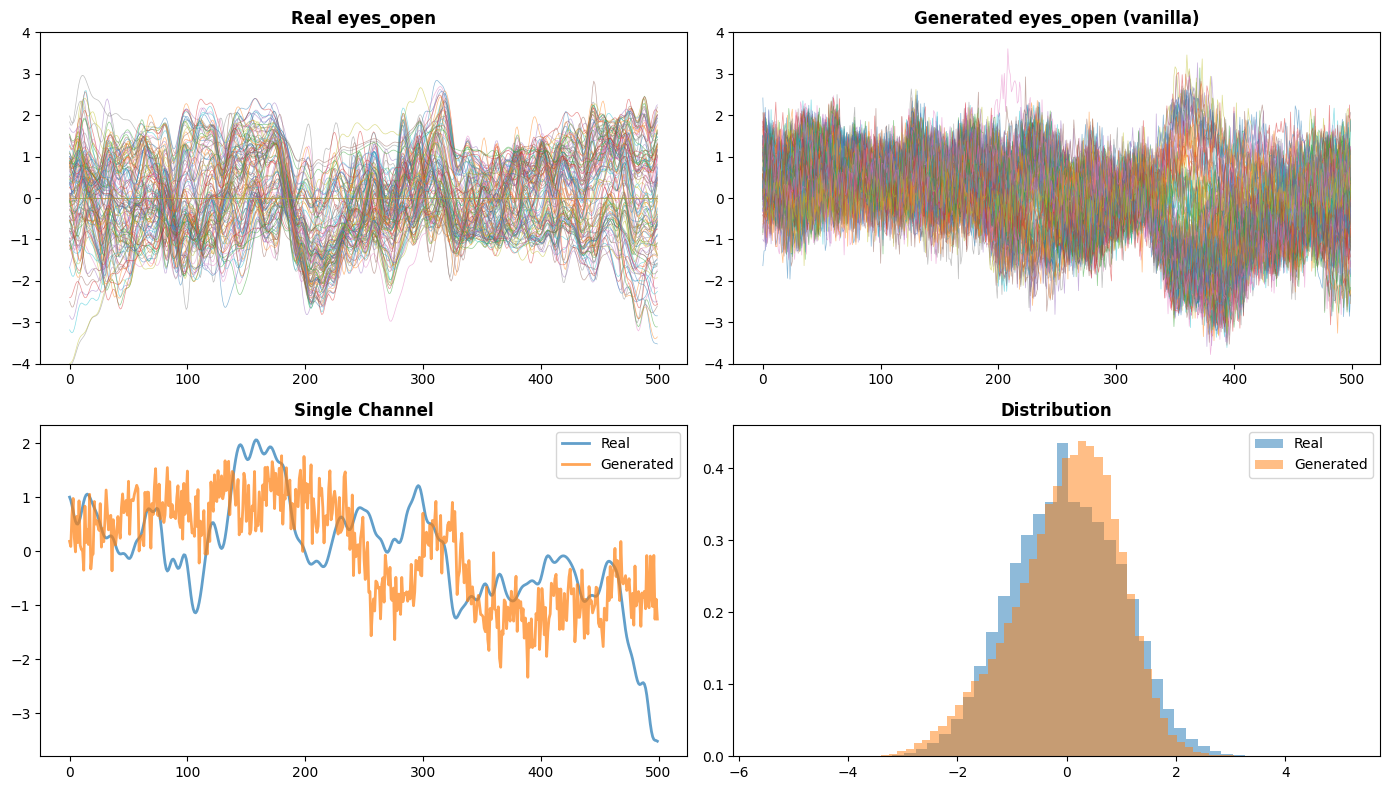

✓ Saved results for eyes_open (vanilla)


In [53]:
# Train eyes open GAN (data already loaded above)
print(f"✓ Using eyes open data: {segments_open.shape}")

# TRAIN IN 3 LINES!
trainer_open = EEGGANTrainer(segments_open, name='eyes_open', device=device, gan_type='vanilla')
trainer_open.train()
synthetic_open = trainer_open.generate(n_samples=100)

# Evaluate
eval_open = trainer_open.evaluate(synthetic_open)
print("\n" + "="*60)
print("EVALUATION RESULTS: EYES OPEN")
print("="*60)
for key, value in eval_open.items():
    print(f"  {key}: {value}")
print("="*60)

# Visualize
trainer_open.plot_comparison(synthetic_open, save_path='../../figures/eyes_open_gan.png')

# Save
trainer_open.save_results(synthetic_open, eval_open)

Initialized EEGGANTrainer (vanilla): eyes_closed
  Data: (66, 129, 500)
  Device: cuda
✓ Models created
  Generator: 167,816,692 params
  Discriminator: 33,190,401 params
✓ Dataset: 66 samples, 3 batches

Training Vanilla GAN for 300 epochs...
Epoch  20/300 | D: 0.1849 | G: 3.9944 | Metric: 0.4804
Epoch  40/300 | D: 0.1932 | G: 4.2221 | Metric: 0.4376
Epoch  60/300 | D: 0.1845 | G: 5.9026 | Metric: 0.3409
Epoch  80/300 | D: 0.2493 | G: 4.6806 | Metric: 0.2789
Epoch 100/300 | D: 0.2154 | G: 5.1261 | Metric: 0.0337
Epoch 120/300 | D: 0.2640 | G: 4.1474 | Metric: 0.0518
Epoch 140/300 | D: 0.3419 | G: 5.1451 | Metric: 0.0797
Epoch 160/300 | D: 0.2435 | G: 4.6634 | Metric: 0.0378
Epoch 180/300 | D: 0.2196 | G: 3.7868 | Metric: 0.0596
Epoch 200/300 | D: 0.2267 | G: 3.8421 | Metric: 0.1546
Epoch 220/300 | D: 0.2322 | G: 3.8720 | Metric: 0.1697
Epoch 240/300 | D: 0.2304 | G: 3.5110 | Metric: 0.2327
Epoch 260/300 | D: 0.2195 | G: 3.7436 | Metric: 0.2404
Epoch 280/300 | D: 0.2241 | G: 3.6849 | M

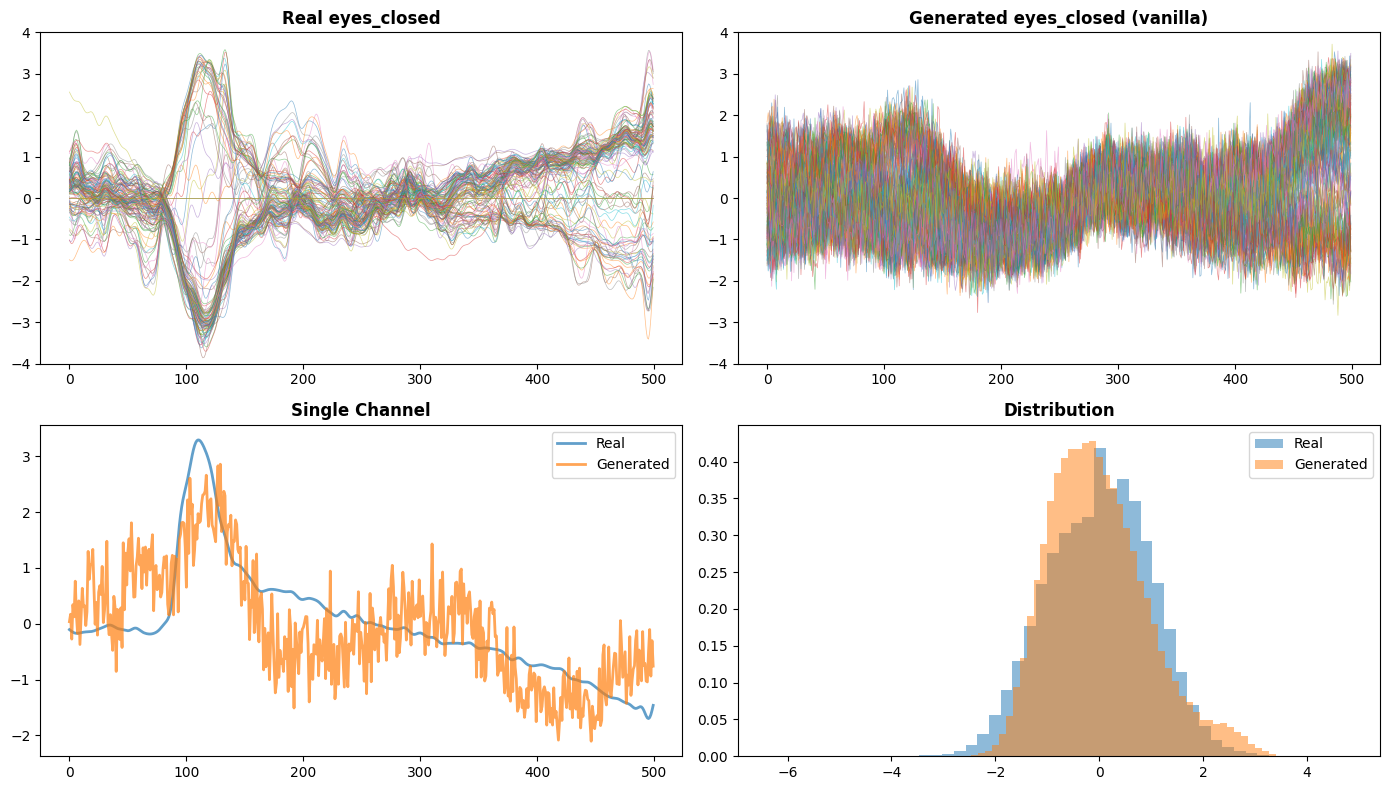

✓ Saved results for eyes_closed (vanilla)


In [54]:
# Extract dimensions
n_channels = segments_closed.shape[1]
n_timepoints = segments_closed.shape[2]

# TRAIN IN 3 LINES!
trainer_closed = EEGGANTrainer(segments_closed, name='eyes_closed', device=device, gan_type='vanilla')
trainer_closed.train()
synthetic_closed = trainer_closed.generate(n_samples=100)

# Evaluate
eval_closed = trainer_closed.evaluate(synthetic_closed)
print("\n" + "="*60)
print("EVALUATION RESULTS: EYES CLOSED")
print("="*60)
for key, value in eval_closed.items():
    print(f"  {key}: {value}")
print("="*60)

# Visualize
trainer_closed.plot_comparison(synthetic_closed, save_path='../../figures/eyes_closed_gan.png')

# Save
trainer_closed.save_results(synthetic_closed, eval_closed)

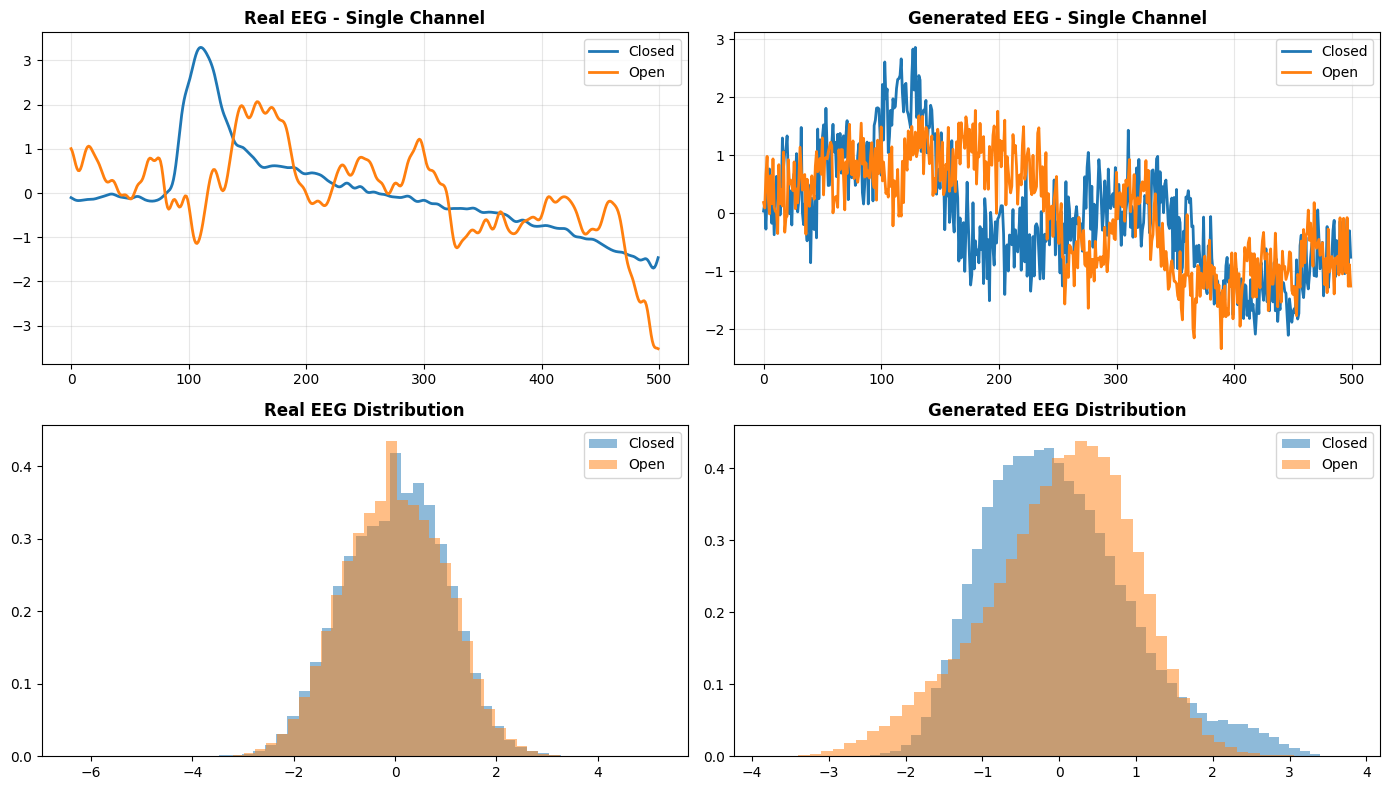


FINAL SUMMARY

Eyes Closed:
  Quality Score: 98.5/100
  Rating: Excellent ⭐⭐⭐⭐⭐

Eyes Open:
  Quality Score: 96.4/100
  Rating: Excellent ⭐⭐⭐⭐⭐

Average: 97.5/100


In [58]:
# Side-by-side comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(segments_closed[0, 0], label='Closed', linewidth=2)
axes[0, 0].plot(segments_open[0, 0], label='Open', linewidth=2)
axes[0, 0].set_title('Real EEG - Single Channel', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(synthetic_closed[0, 0], label='Closed', linewidth=2)
axes[0, 1].plot(synthetic_open[0, 0], label='Open', linewidth=2)
axes[0, 1].set_title('Generated EEG - Single Channel', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(segments_closed.flatten(), bins=50, alpha=0.5, label='Closed', density=True)
axes[1, 0].hist(segments_open.flatten(), bins=50, alpha=0.5, label='Open', density=True)
axes[1, 0].set_title('Real EEG Distribution', fontweight='bold')
axes[1, 0].legend()

axes[1, 1].hist(synthetic_closed.flatten(), bins=50, alpha=0.5, label='Closed', density=True)
axes[1, 1].hist(synthetic_open.flatten(), bins=50, alpha=0.5, label='Open', density=True)
axes[1, 1].set_title('Generated EEG Distribution', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../../figures/closed_vs_open_final.png', dpi=150)
plt.show()

# Summary report
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\nEyes Closed:")
print(f"  Quality Score: {eval_closed['overall_score']:.1f}/100")
print(f"  Rating: {eval_closed['quality']}")
print(f"\nEyes Open:")
print(f"  Quality Score: {eval_open['overall_score']:.1f}/100")
print(f"  Rating: {eval_open['quality']}")
print(f"\nAverage: {(eval_closed['overall_score'] + eval_open['overall_score'])/2:.1f}/100")
print("="*70)

✓ Saved results for eyes_closed (vanilla)


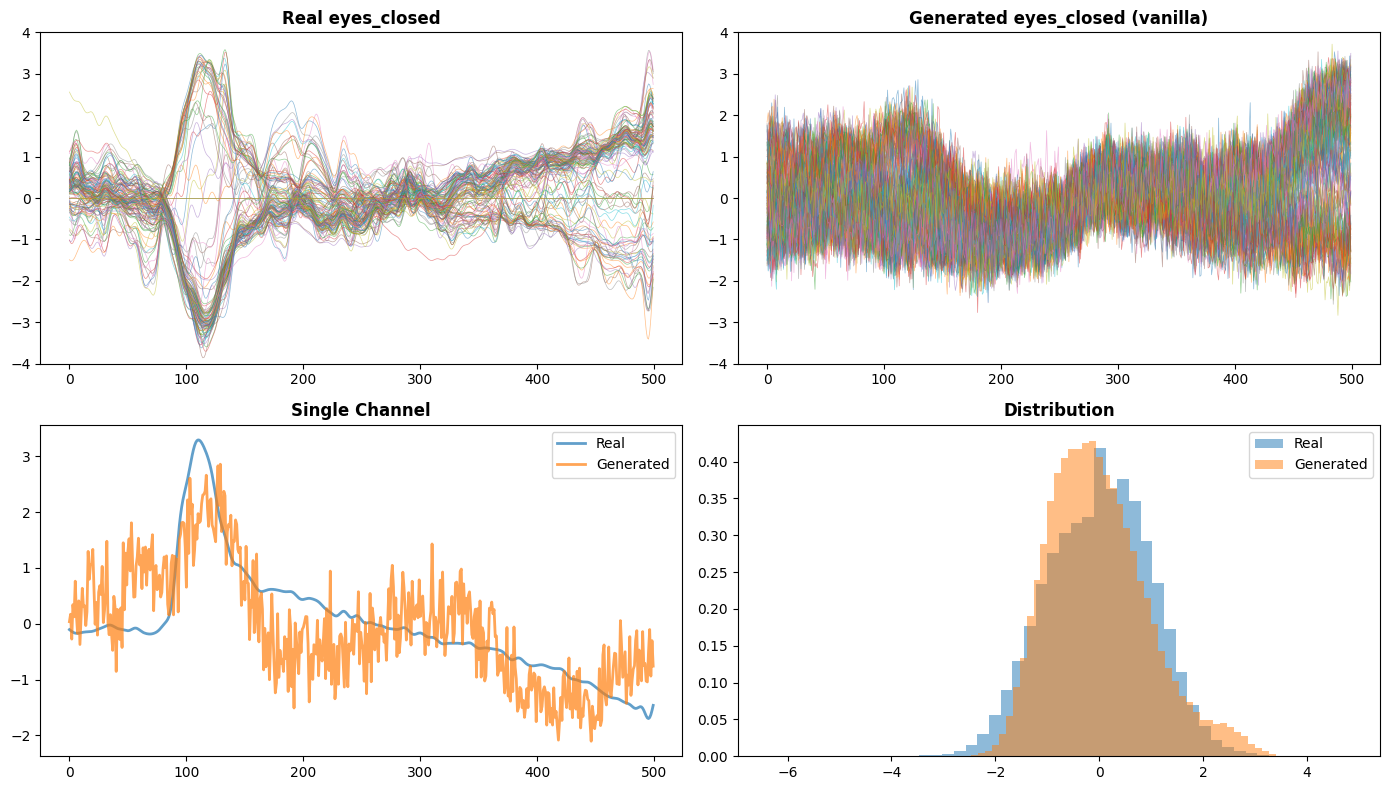

✓ Saved results for eyes_open (vanilla)


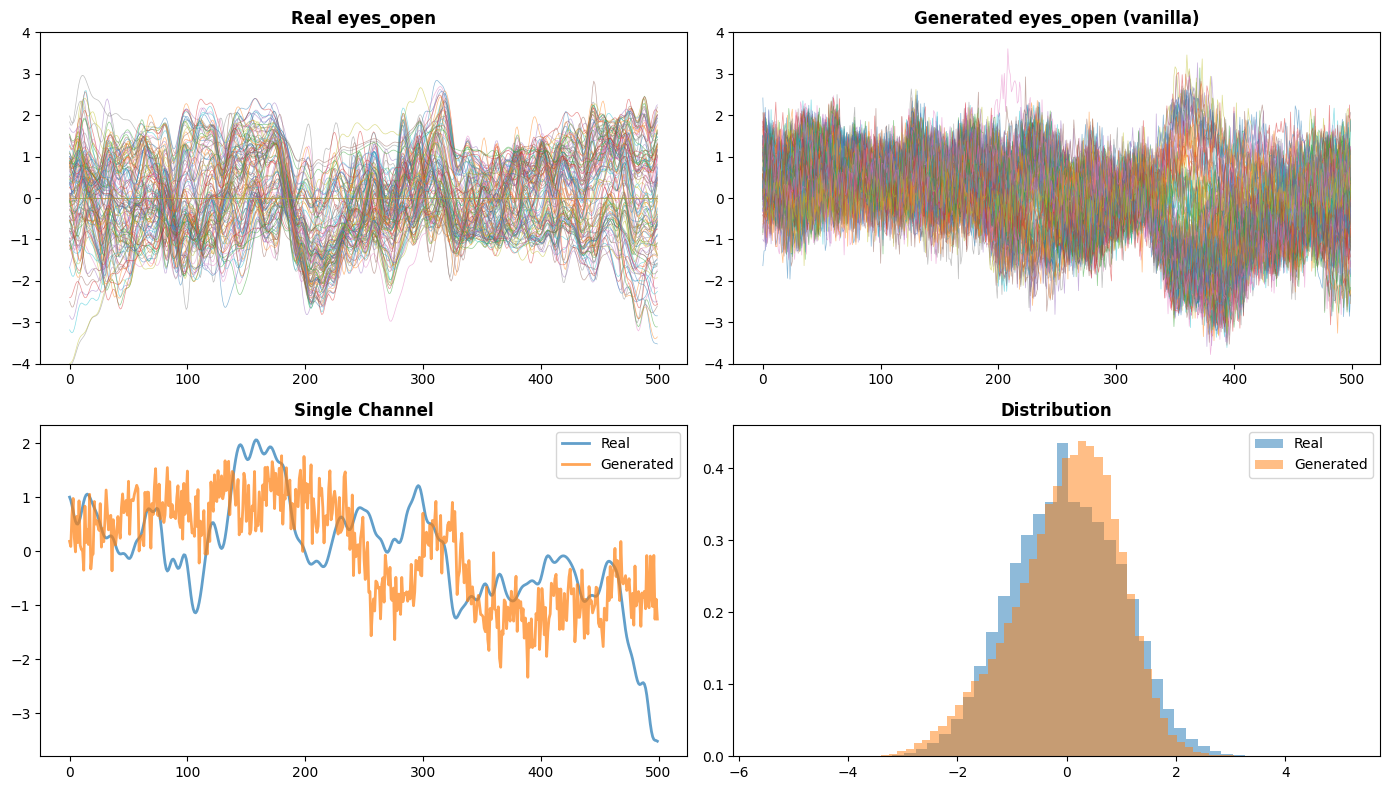

In [60]:
# save results if needed
trainer_closed.save_results(synthetic_closed, eval_closed)
trainer_closed.plot_comparison(synthetic_closed, save_path='../../figures/eyes_closed_gan.png')

trainer_open.save_results(synthetic_open, eval_open)
trainer_open.plot_comparison(synthetic_open, save_path='../../figures/eyes_open_gan.png')

# save model
trainer_closed.save_model()
trainer_open.save_model()